In [1]:
###################################################################################################
#
# PairIdentification.py
#
# Copyright (C) by Andreas Zoglauer & Harrison Costatino.
#
# Please see the file LICENSE in the main repository for the copyright-notice.
#
###################################################################################################



###################################################################################################

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

import numpy as np

#from mpl_toolkits.mplot3d import Axes3D
#import matplotlib.pyplot as plt

import random

import signal
import sys
import time
import math
import csv
import os
import argparse
import logging
import yaml
from datetime import datetime
from functools import reduce


print("\nPair Identification")
print("============================\n")



# Step 1: Input parameters
###################################################################################################


# Default parameters

# Split between training and testing data
TestingTrainingSplit = 0.1

MaxEvents = 1000

# File names
FileName = "PairIdentification.p1.sim.gz"
GeometryName = "$(MEGALIB)/resource/examples/geomega/GRIPS/GRIPS.geo.setup"


# Set in stone later
TestingTrainingSplit = 0.8

OutputDirectory = "Results"


parser = argparse.ArgumentParser(description='Perform training and/or testing of the pair identification machine learning tools.')
parser.add_argument('-d', '--datatype', default='tm2', help='One of: tm1: toy modle #1, tm2: toy model #2, f: file')
parser.add_argument('-f', '--filename', default='PairIdentification.p1.sim.gz', help='File name used for training/testing')
parser.add_argument('-m', '--maxevents', default='100', help='Maximum number of events to use')
parser.add_argument('-s', '--testingtrainigsplit', default='0.1', help='Testing-training split')
parser.add_argument('-b', '--batchsize', default='16', help='Batch size')

# Command line arguments for build model, to remove dependency on .yaml
parser.add_argument('--model_type', default='gnn_segment_classifier', help='model_type')
parser.add_argument('--optimizer', default='Adam', help='optimizer')
parser.add_argument('--learning_rate', default='0.001', help='learning_rate')
parser.add_argument('--loss_func', default='BCELoss', help='loss_func')
parser.add_argument('--input_dim', default='3', help='input_dim')
parser.add_argument('--hidden_dim', default='64', help='hidden_dim')
parser.add_argument('--n_iters', default='100', help='n_iters')
# parser.add_argument('--hidden_activation', default='nn.Tanh', help='hidden_activation')


args = parser.parse_args()

DataType = args.datatype

if args.filename != "":
  FileName = args.filename

if int(args.maxevents) >= 10:
  MaxEvents = int(args.maxevents)

if int(args.batchsize) >= 0:
  BatchSize = int(args.batchsize)

if float(args.testingtrainigsplit) >= 0.05:
  TestingTrainingSplit = float(args.testingtrainigsplit)


if os.path.exists(OutputDirectory):
  Now = datetime.now()
  OutputDirectory += Now.strftime("_%Y%m%d_%H%M%S")

os.makedirs(OutputDirectory)



###################################################################################################
# Step 2: Global functions
###################################################################################################


# Take care of Ctrl-C
Interrupted = False
NInterrupts = 0
def signal_handler(signal, frame):
  global Interrupted
  Interrupted = True
  global NInterrupts
  NInterrupts += 1
  if NInterrupts >= 2:
    print("Aborting!")
    sys.exit(0)
  print("You pressed Ctrl+C - waiting for graceful abort, or press  Ctrl-C again, for quick exit.")
signal.signal(signal.SIGINT, signal_handler)


# Everything ROOT related can only be loaded here otherwise it interferes with the argparse
from EventData import EventData

# Load MEGAlib into ROOT so that it is usable
import ROOT as M
M.gSystem.Load("$(MEGALIB)/lib/libMEGAlib.so")
M.PyConfig.IgnoreCommandLineOptions = True



###################################################################################################
# Step 3: Create some training, test & verification data sets
###################################################################################################


# Read the simulation file data:
DataSets = []
NumberOfDataSets = 0

if DataType == "tm1":
  for e in range(0, MaxEvents):
    Data = EventData()
    Data.createFromToyModelRealismLevel1(e)
    DataSets.append(Data)
    
    NumberOfDataSets += 1
    if NumberOfDataSets > 0 and NumberOfDataSets % 1000 == 0:
      print("Data sets processed: {}".format(NumberOfDataSets))

elif DataType == "tm2":
  for e in range(0, MaxEvents):
    Data = EventData()
    Data.createFromToyModelRealismLevel2(e)
    DataSets.append(Data)
    
    NumberOfDataSets += 1
    if NumberOfDataSets > 0 and NumberOfDataSets % 1000 == 0:
      print("Data sets processed: {}".format(NumberOfDataSets))

elif DataType == "f":
  # Load geometry:
  Geometry = M.MDGeometryQuest()
  if Geometry.ScanSetupFile(M.MString(GeometryName)) == True:
    print("Geometry " + GeometryName + " loaded!")
  else:
    print("Unable to load geometry " + GeometryName + " - Aborting!")
    quit()


  Reader = M.MFileEventsSim(Geometry)
  if Reader.Open(M.MString(FileName)) == False:
    print("Unable to open file " + FileName + ". Aborting!")
    quit()


  print("\n\nStarted reading data sets")
  NumberOfDataSets = 0
  while NumberOfDataSets < MaxEvents:
    Event = Reader.GetNextEvent()
    if not Event:
      break

    if Event.GetNIAs() > 0:
      Data = EventData()
      if Data.parse(Event) == True:
        if Data.hasHitsOutside(XMin, XMax, YMin, YMax, ZMin, ZMax) == False:
          DataSets.append(Data)
          NumberOfDataSets += 1
          if NumberOfDataSets % 500 == 0:
            print("Data sets processed: {}".format(NumberOfDataSets))

else:
  print("Unknown data type \"{}\" Must be one of tm1, tm2, f".format(DataType))
  quit()

print("Info: Parsed {} events".format(NumberOfDataSets))

# Split the data sets in training and testing data sets

TestingTrainingSplit = 0.75


numEvents = len(DataSets)

numTraining = int(numEvents * TestingTrainingSplit)

TrainingDataSets = DataSets[:numTraining]
TestingDataSets = DataSets[numTraining:]



# For testing/validation split
# ValidationDataSets = TestingDataSets[:int(len(TestingDataSets)/2)]
# TestingDataSets = TestingDataSets[int(len(TestingDataSets)/2):]

print("###### Data Split ########")
print("Training/Testing Split: {}".format(TestingTrainingSplit))
print("Total Data: {}, Training Data: {},Testing Data: {}".format(numEvents, len(TrainingDataSets), len(TestingDataSets)))
print("##########################")


###################################################################################################
# Step 4: Vectorize data using preprocess.py
###################################################################################################

from preprocess import generate_incidence, connect_pos, vectorize_data
import torch
import torch.distributed as dist
from torch.utils.data import DataLoader
from torch.utils.data.distributed import DistributedSampler

# Locals
from datasets import get_data_loaders
from trainers import get_trainer

train_Edge_Labels, train_Man_Ri, train_Man_Ro, train_XYZ, train_Type, train_Energy, train_GammaEnergy = vectorize_data(TrainingDataSets)
test_Edge_Labels, test_Man_Ri, test_Man_Ro, test_XYZ, test_Type, test_Energy, test_GammaEnergy = vectorize_data(TestingDataSets)

train_features = [[train_XYZ[i], train_Man_Ri[i], train_Man_Ro[i]] for i in range(train_XYZ.shape[0])]
train_labels = train_Edge_Labels

test_features = [[test_XYZ[i], test_Man_Ri[i], test_Man_Ro[i]] for i in range(test_XYZ.shape[0])]
test_labels = test_Edge_Labels

train_dataset = [[train_features[i],train_labels[i]] for i in range(train_XYZ.shape[0])]
test_dataset = [[test_features[i],test_labels[i]] for i in range(test_XYZ.shape[0])] 

train_data_loader = DataLoader(train_dataset, batch_size=BatchSize)
valid_data_loader = DataLoader(test_dataset, batch_size=BatchSize)


Pair Identification

Welcome to JupyROOT 6.18/04
Added Bremsstrahlung hits
Added Bremsstrahlung hits
Eliminate hit 8 at 0.03162809600549982 -5.722370143953478 16.0
Eliminate hit 9 at -3.0729974186818225 -3.946131964376501 17.0
Eliminate hit 10 at -3.705302964072436 -4.044562313623526 18.0
Event ID: 0
  Origin Z: 15
  Gamma Energy: 10000.0
  Hit 1 (origin: 0): type=e, pos=(-0.4251234216746935, -5.600673054917733, 15.0)cm, E=823.6161282798209keV
  Hit 2 (origin: 1): type=e, pos=(-1.1167174395222954, -11.523687625469469, 16.0)cm, E=680.6493261815972keV
  Hit 3 (origin: 2): type=e, pos=(1.2858625165075401, -7.230325689263646, 17.0)cm, E=762.5620969735426keV
  Hit 4 (origin: 3): type=e, pos=(3.605043450458505, -10.208392036656996, 16.0)cm, E=858.1542632148228keV
  Hit 5 (origin: 4): type=e, pos=(4.360439816051418, -11.141422170947804, 15.0)cm, E=895.8203959661895keV
  Hit 6 (origin: 5): type=e, pos=(3.414612543030138, -11.442300668080392, 14.0)cm, E=947.6264930306439keV
  Hit 7 (origin: 6)

Event ID: 67
  Origin Z: 7
  Gamma Energy: 9999.999999999998
  Hit 1 (origin: 0): type=e, pos=(16.444693783594495, 13.018398462382198, 7.0)cm, E=485.8406538180617keV
  Hit 2 (origin: 1): type=e, pos=(16.77674027261348, 11.007761346570959, 6.0)cm, E=547.4865460832476keV
  Hit 3 (origin: 2): type=e, pos=(17.46594595183887, 12.808836116306527, 5.0)cm, E=590.0333472312059keV
  Hit 4 (origin: 3): type=e, pos=(-22.55636154420829, 14.699962041363442, 3.0)cm, E=693.2745644324958keV
  Hit 5 (origin: 4): type=e, pos=(-21.821792961377415, 15.746235065254456, 4.0)cm, E=734.7280921092333keV
  Hit 6 (origin: 5): type=e, pos=(-13.906611671655254, 18.81569206496491, 5.0)cm, E=790.1199442760598keV
  Hit 7 (origin: 6): type=e, pos=(-12.709570064935434, 18.805475230117196, 4.0)cm, E=839.0037843127852keV
  Hit 8 (origin: 7): type=e, pos=(-12.713046459411617, 18.691350709452344, 3.0)cm, E=888.6380433301161keV
  Hit 9 (origin: 8): type=e, pos=(-14.574313086861652, 19.417636175223006, 2.0)cm, E=931.354061244

In [2]:
###################################################################################################
# Step 5: Setting up the neural network
###################################################################################################

# trainer = get_trainer(distributed=args.distributed, output_dir=output_dir,
#                           device=args.device, **experiment_config)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using", "cuda:0" if torch.cuda.is_available() else "cpu", "for training.")

trainer = get_trainer(name='gnn', device=device)

# Build the model
# trainer.build_model(**model_config)

'''
model_config:
    model_type: 'gnn_segment_classifier'
    input_dim: 3
    hidden_dim: 64
    n_iters: 4
    loss_func: 'BCELoss'
    optimizer: 'Adam'
    learning_rate: 0.001
'''
model_type = args.model_type
optimizer = args.optimizer
learning_rate = float(args.learning_rate)
loss_func = args.loss_func
input_dim = int(args.input_dim)
hidden_dim = int(args.hidden_dim)
n_iters = 5

trainer.build_model(model_type=model_type, optimizer=optimizer, learning_rate=learning_rate, loss_func=loss_func, 
  input_dim=3, hidden_dim=hidden_dim, n_iters=n_iters)

# if not args.distributed or (dist.get_rank() == 0):
#     trainer.print_model_summary()

###################################################################################################
# Step 6: Training the network
###################################################################################################

summary = trainer.train(train_data_loader=train_data_loader,
                        valid_data_loader=valid_data_loader, n_epochs=n_iters)

print('Train Loss Log: ', summary['train_loss'])
print('Final Test Accuracy: ', summary['valid_acc'][-1])
print('Max Test Accuracy: ', max(summary['valid_acc']))


trainer.write_summaries("Results/result", summary)

###################################################################################################
# Step 7: Evaluating the network
###################################################################################################



Using cpu for training.
Ported Model to Device
Finished Building Model
Batch 0 Loss: 0.7166081070899963
Batch 1 Loss: 0.6973850131034851
Batch 2 Loss: 0.7026905417442322
Batch 3 Loss: 0.6884428858757019
Batch 4 Loss: 0.6944993734359741
Batch 0 Loss: 0.6844322681427002
Batch 1 Loss: 0.6763572692871094
Batch 2 Loss: 0.6743159294128418
Batch 3 Loss: 0.6630619764328003
Batch 4 Loss: 0.6618621349334717
Batch 0 Loss: 0.668649435043335
Batch 1 Loss: 0.6575140953063965
Batch 2 Loss: 0.6503944993019104
Batch 3 Loss: 0.643512487411499
Batch 4 Loss: 0.6270369291305542
Batch 0 Loss: 0.6480219960212708
Batch 1 Loss: 0.637297511100769
Batch 2 Loss: 0.6286762952804565
Batch 3 Loss: 0.6227853298187256
Batch 4 Loss: 0.5867751240730286
Batch 0 Loss: 0.6213395595550537
Batch 1 Loss: 0.6180274486541748
Batch 2 Loss: 0.609565258026123
Batch 3 Loss: 0.6077560186386108
Batch 4 Loss: 0.5602338910102844
Train Loss Log:  [0.6999251842498779, 0.6720059156417847, 0.649421489238739, 0.6247112512588501, 0.603384435

In [47]:
import matplotlib.pyplot as plt
import numpy as np

def add_arrow(line, position=None, direction='right', size=15, color=None):
    """
    add an arrow to a line.

    line:       Line2D object
    position:   x-position of the arrow. If None, mean of xdata is taken
    direction:  'left' or 'right'
    size:       size of the arrow in fontsize points
    color:      if None, line color is taken.
    """
    if color is None:
        color = line.get_color()

    xdata = line.get_xdata()
    ydata = line.get_ydata()

    if position is None:
        position = xdata.mean()
    # find closest index
    start_ind = np.argmin(np.absolute(xdata - position))
    if direction == 'right':
        end_ind = start_ind + 1
    else:
        end_ind = start_ind - 1

    line.axes.annotate('',
        xytext=(xdata[start_ind], ydata[start_ind]),
        xy=(xdata[end_ind], ydata[end_ind]),
        arrowprops=dict(arrowstyle="->", color=color),
        size=size
    )


def draw_vertices_xy(points):
    plt.plot(points[:, 0], points[:, 1], 'o', c='black')

def draw_edge_xy(ptA, ptB, correct=False):
    x_coords = np.array([ptA[0], ptB[0]])
    y_coords = np.array([ptA[1], ptB[1]])
    if correct:
        line = plt.plot(x_coords, y_coords, 'green')[0]
        # add_arrow(line)
    else:
        line = plt.plot(x_coords, y_coords, 'red')[0]
        # add_arrow(line)

def draw_edge_xyz(ptA, ptB, correct=True):
    x_coords = np.array([ptA[0], ptB[0]])
    y_coords = np.array([ptA[1], ptB[1]])
    z_coords = np.array([ptA[2], ptB[2]])

    if correct:
        line = plt.plot(x_coords, y_coords, z_coords, 'green')[0]
#         add_arrow(line)
    else:
        line = plt.plot(x_coords, y_coords, z_coords, 'red')[0]
#         add_arrow(line)

# pos is (max_hits, 3) containing XYZ
# Rin, Rout is (max_hits, max_edges)
# Edge_Labels is (1, max_edges), 1 if actually present
# plot_fn is a plotting function taking two points and a correct label

def draw_plot(pos, Rin, Rout, Edge_Labels):
    num_edges = Rin.shape[1]
    for edge_idx in range(num_edges):
        # checking if edge or padding
        if sum(Rin[:, edge_idx]) != 0:
            ptA_idx = np.nonzero(Rout[:, edge_idx])[0][0]
            ptB_idx = np.nonzero(Rin[:, edge_idx])[0][0]
            
            ptA = pos[ptA_idx]
            ptB = pos[ptB_idx]
            
            correct = Edge_Labels[edge_idx]
            draw_edge_xy(ptA, ptB, correct)
    
def draw_3d_plot(pos, Rin, Rout, Edge_Labels):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(pos[:, 0], pos[:, 1], pos[:, 2])
    num_edges = Rin.shape[1]
    for edge_idx in range(num_edges):
        # checking if edge or padding
        if sum(Rin[:, edge_idx]) != 0:
            ptA_idx = np.nonzero(Rout[:, edge_idx])[0][0]
            ptB_idx = np.nonzero(Rin[:, edge_idx])[0][0]
            
            ptA = pos[ptA_idx]
            ptB = pos[ptB_idx]
            
            correct = Edge_Labels[edge_idx]
            draw_edge_xyz(ptA, ptB, correct)

In [38]:
summary['X'][4][0]

tensor([[ 13.1707, -18.5719,  -1.0000],
        [220.4692,   9.9363,   2.0000],
        [ 10.3507, -14.5373,   0.0000],
        [ 12.5914, -13.9100,   1.0000],
        [ 41.9475,  -7.2170,  -1.0000],
        [ 48.6195, -15.1108,  -2.0000],
        [ 50.0714, -15.7134,  -3.0000],
        [ 49.5313, -19.4175,  -5.0000],
        [ 69.0981,  -5.9138,  -6.0000],
        [  0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000]])

In [39]:
len(summary['X'][4])

25

In [33]:
summary['X'][4][0].shape

torch.Size([14, 3])

In [34]:
summary['Ro'][4][0].shape

torch.Size([14, 60])

In [35]:
summary['Edge_Labels'][4][0].shape

(60,)

In [22]:
summary['Edge_Labels'][4][0]

array([False, False, False, False,  True, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False])

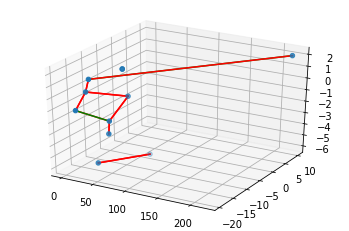

In [42]:
draw_3d_plot(summary['X'][4][0], summary['Ri'][4][0], summary['Ro'][4][0], summary['Edge_Labels'][4][0])

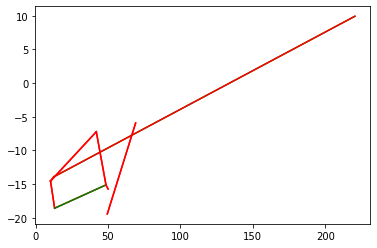

In [48]:
draw_plot(summary['X'][4][0], summary['Ri'][4][0], summary['Ro'][4][0], summary['Edge_Labels'][4][0])